In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import vxs
import vxs.utils as vxsu

In [2]:
avp_set_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed', recordings_type='hits')
avp_set_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset', subset='Personal', recordings_type='hits')

../data/avp-dataset/AVP_Dataset/Personal/Participant_20/P20_HHclosed_Personal.wav


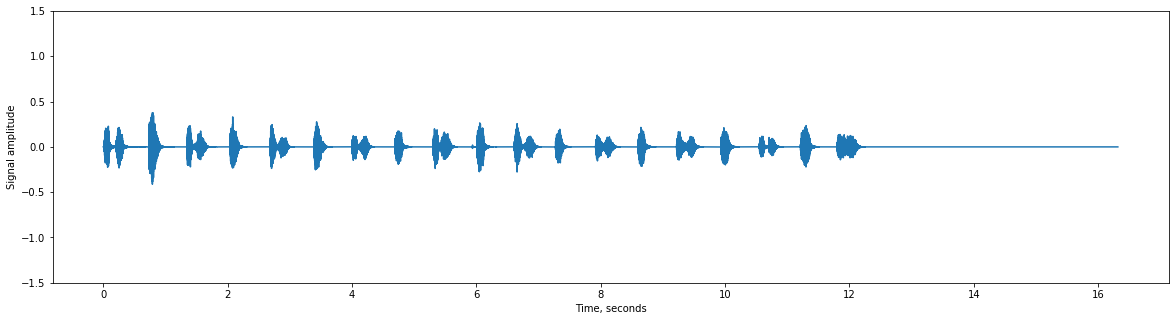

In [6]:
track, anno = avp_set_personal.get('P20_HHclosed_Personal')
vxsu.display_track(track)

In [8]:
fixed_segments = vxs.SegmentSet(avp_set_fixed, frame_window=None)

In [11]:
min_segm_lens = dict((cl, 100000) for cl in ['kd', 'sd', 'hhc', 'hho'])
for segm, cl in fixed_segments:
    min_segm_lens[cl] = min(min_segm_lens[cl], segm.n_samples)

In [13]:
min_segm_lens

{'kd': 4160, 'sd': 4287, 'hhc': 56, 'hho': 0}

In [14]:
max_segm_lens = dict((cl, 0) for cl in ['kd', 'sd', 'hhc', 'hho'])
for segm, cl in fixed_segments:
    max_segm_lens[cl] = max(max_segm_lens[cl], segm.n_samples)

In [15]:
max_segm_lens

{'kd': 579120, 'sd': 581744, 'hhc': 628327, 'hho': 580672}